In [2]:
import os
import pandas as pd
import numpy as np
import calendar
import base64
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import stop_words
# from sklearn.grid_search import GridSearchCV
# import SGD classifier
from sklearn.linear_model import SGDClassifier
# pipeline
from sklearn.pipeline import Pipeline
# define pipeline
pipeline = Pipeline([
                        ('vect',CountVectorizer()),
                         ('tfidf',TfidfVectorizer()),
                        ('clf',SGDClassifier())
                   ])

import gensim
import pyLDAvis.gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer,PorterStemmer
from nltk.stem.porter import *
import nltk

np.random.seed(400)

# External running pythons
# %run -i python-code/nlp.py

# Folder path
folder = './run_data/'
folder_traing = './training/'
dest_file = './final/final_content.csv'

%matplotlib inline

C:\Users\Shaynie\Anaconda3\envs\capstone_app\lib\site-packages\requests\__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.2) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


## Datetime

In [2]:
files = os.listdir(folder)
print("Total: ", len(files))

dates = []
texts = []
for f_ in files:
    file = folder + f_
    print(file)
    df_temp = pd.read_csv(file,sep='|')    
    df_temp = df_temp[pd.notnull(df_temp['contents'])]
    
    # Push datetime with content to list
    contents = df_temp['date'].values
    contents2 = df_temp['contents'].values
    
    dates.extend(contents)
    texts.extend(contents2)

    print("dates: ", len(dates))
    print("================\n")


Total:  12
./run_data/bbc_scrapt_v2.csv
dates:  2913

./run_data/cnn_scrapt_v2.csv
dates:  3922

./run_data/everyday_scrapt_v2.csv
dates:  5234

./run_data/gdnhealth_scrapt_v2.csv
dates:  7271

./run_data/goodhealth_scrapt_v2.csv
dates:  8694

./run_data/kaiserhealth_scrapt_v2.csv
dates:  8795

./run_data/latimes_scrapt_v2.csv
dates:  10285

./run_data/nbc_scrapt_v2.csv
dates:  12182

./run_data/npr_scrapt_v2.csv
dates:  16860

./run_data/nytimes_scrapt_v2.csv
dates:  19083

./run_data/reuters_scrapt_v2.csv
dates:  20275

./run_data/wsj_scrapt_v2.csv
dates:  22172



In [3]:
df_datetime = pd.DataFrame(zip(dates,texts),columns=['date','content'])
df_datetime['date'] = pd.to_datetime(df_datetime['date']) 
df_datetime['length'] = df_datetime['content'].apply(lambda row: len(row))
df_datetime = df_datetime[df_datetime['length'] > 200]

df_datetime.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21215 entries, 0 to 22171
Data columns (total 3 columns):
date       21215 non-null datetime64[ns, UTC]
content    21215 non-null object
length     21215 non-null int64
dtypes: datetime64[ns, UTC](1), int64(1), object(1)
memory usage: 663.0+ KB


In [4]:
# Ref: http://strftime.org/
df_datetime['year'] = df_datetime['date'].dt.strftime("%Y")
df_datetime['month'] = df_datetime['date'].dt.strftime('%m')
df_datetime['day'] = df_datetime['date'].dt.strftime('%d')
df_datetime['weekday'] = df_datetime['date'].dt.strftime('%w')
df_datetime['hour'] = df_datetime['date'].dt.hour
df_datetime['minutes'] = df_datetime['date'].dt.strftime('%M')
df_datetime.head()

,date,content,length,year,month,day,weekday,hour,minutes
0,2015-04-09 01:31:50+00:00,Scientists have predicted the odds of women de...,3407,2015,04,09,4,1,31
1,2015-04-08 23:30:18+00:00,Better funding and more time with patients are...,3665,2015,04,08,3,23,30
2,2015-04-08 23:30:18+00:00,"The shorter you are, the greater your risk of ...",2659,2015,04,08,3,23,30
3,2015-04-08 18:05:28+00:00,The first human trial of a new type of HIV the...,2659,2015,04,08,3,18,05
4,2015-04-08 13:19:33+00:00,"The government has ""undermined and weakened"" t...",2066,2015,04,08,3,13,19


Text(0.5, 0.98, 'Distributions of content over the year')

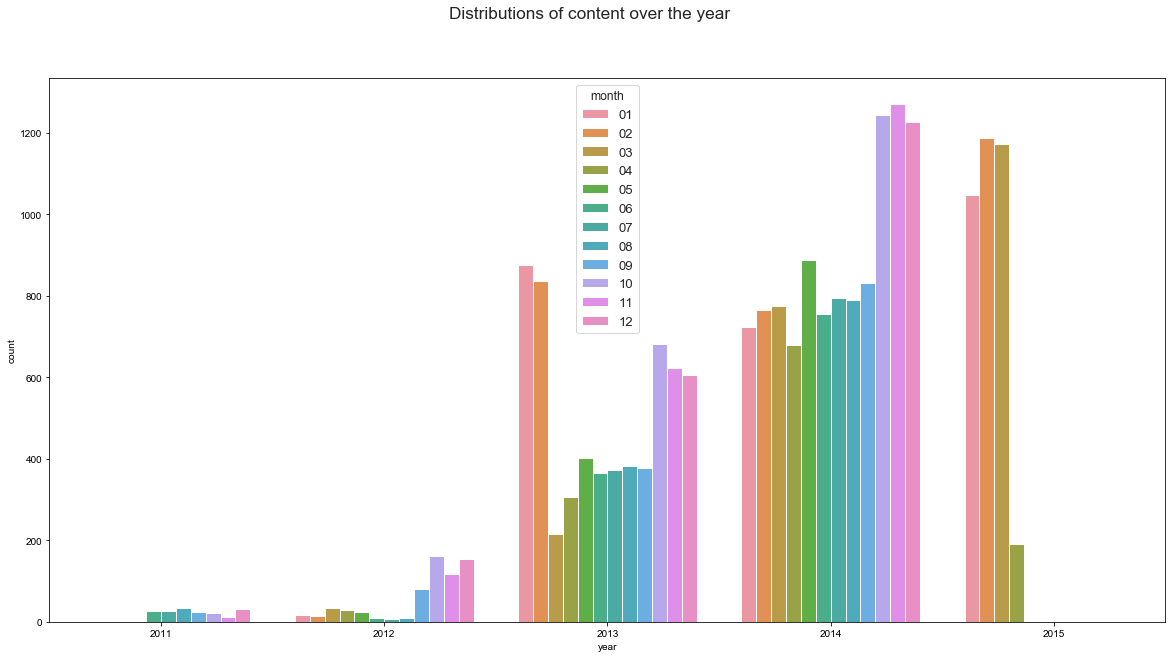

In [5]:
fig, ax = plt.subplots(1,1, figsize=(20,10))
sns.set(style="whitegrid", color_codes=True, font_scale=1.2)
# sns.countplot(x='year', data=df_datetime, orient='h')
sns.countplot(x='year',hue='month', data=df_datetime, orient='h')
fig.suptitle('Distributions of content over the year')

Text(0.5, 0.98, 'Distributions of content over month')

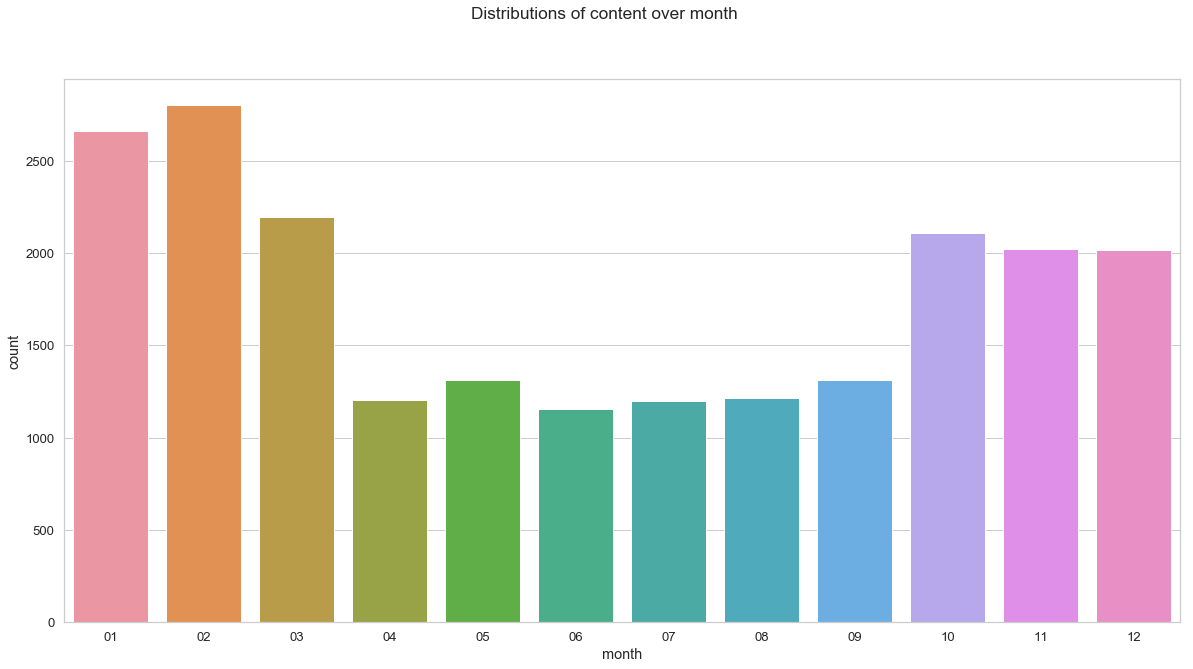

In [6]:
# order=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
fig, ax = plt.subplots(1,1, figsize=(20,10))

dict_month = df_datetime['month'].value_counts().sort_index().to_dict()
sns.countplot(x='month',data=df_datetime)
"\n",
fig.suptitle('Distributions of content over month')

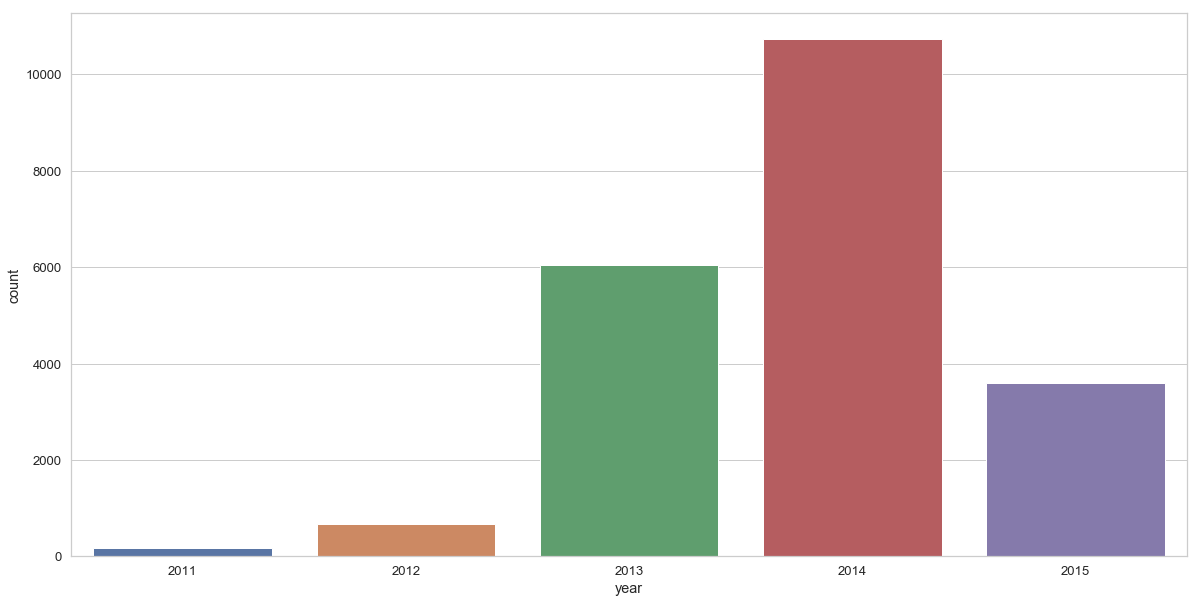

In [7]:
fig, ax = plt.subplots(1,1, figsize=(20,10))
sns.countplot(x='year',data=df_datetime)

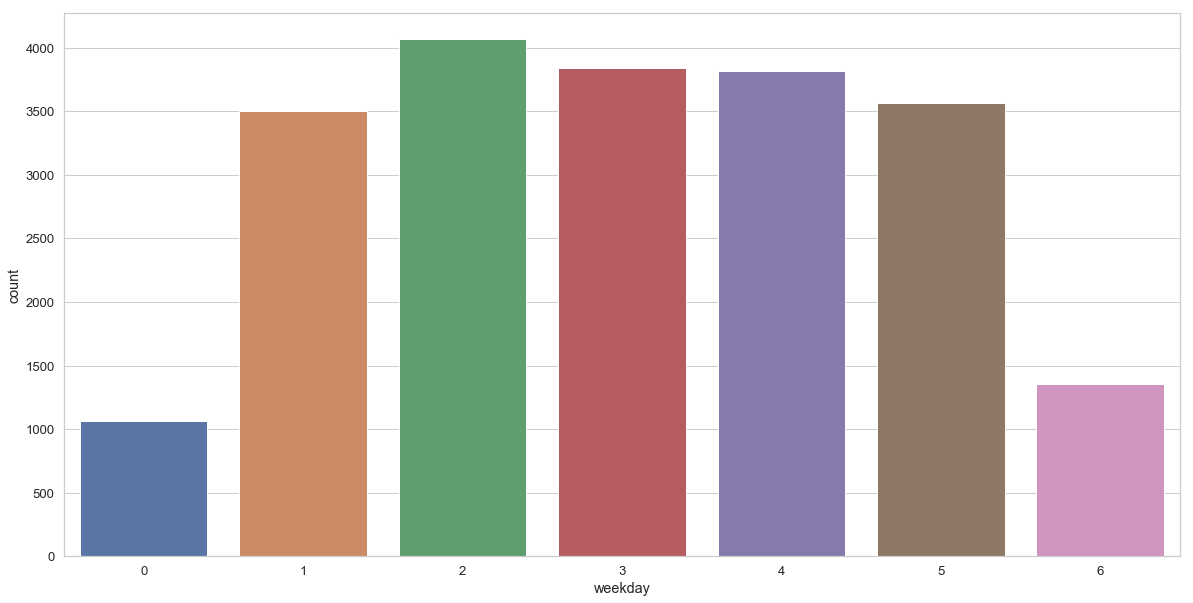

In [8]:
fig, ax = plt.subplots(1,1, figsize=(20,10))

sns.countplot(x='weekday', data=df_datetime)

Text(0.5, 0.98, 'Distributions of text during a day')

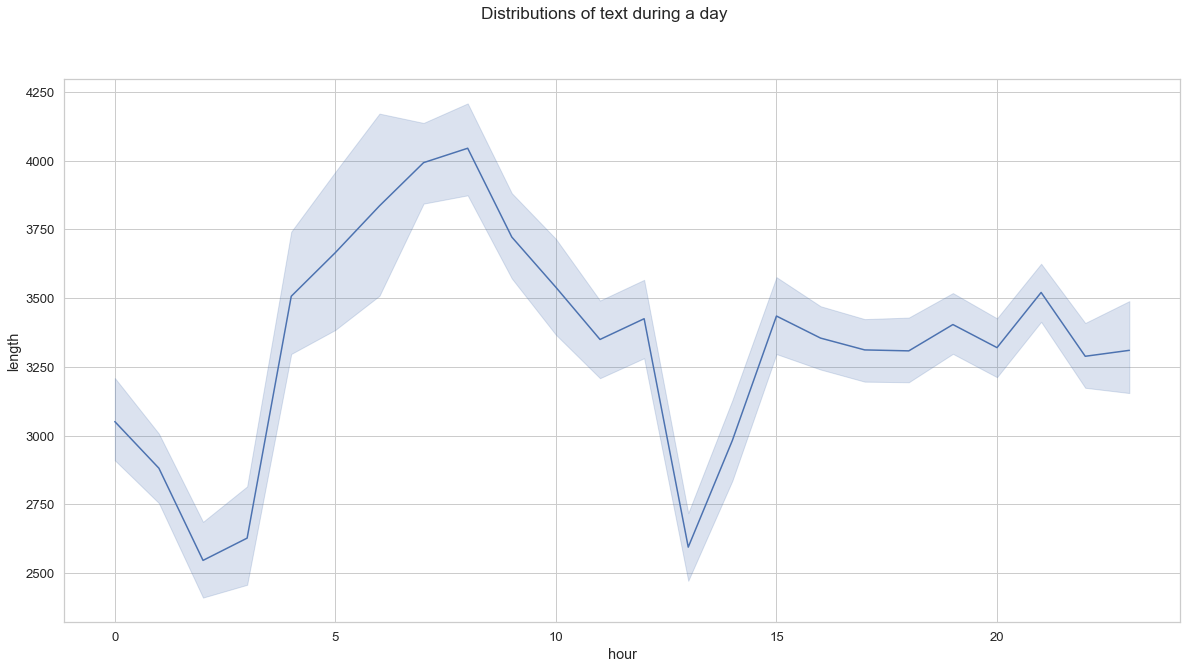

In [9]:
fig, ax = plt.subplots(1,1, figsize=(20,10))
sns.lineplot(x='hour', y='length', data=df_datetime,  color='C0')
fig.suptitle('Distributions of text during a day')

Text(0.5, 0.98, 'Length of text for each title')

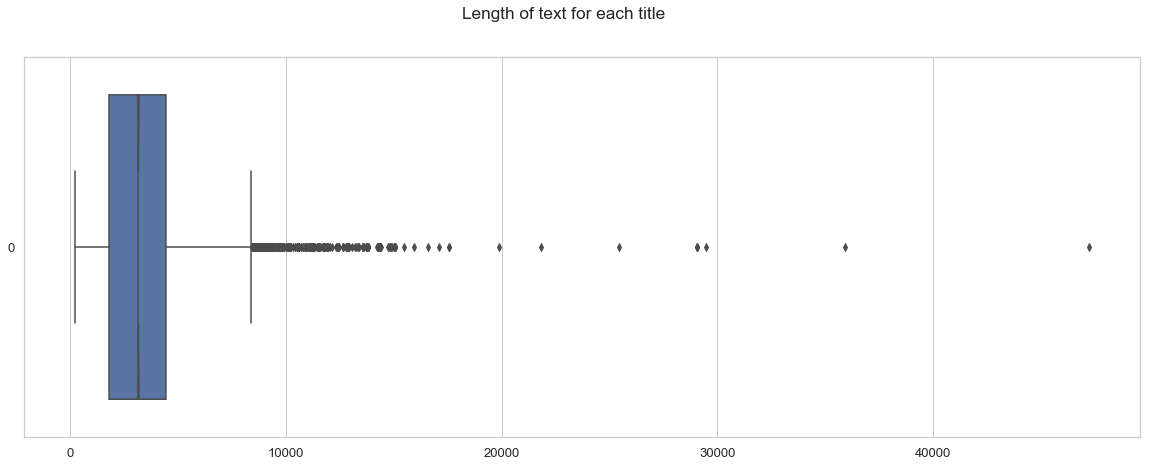

In [10]:
fig, ax = plt.subplots(1,1, figsize=(20,7))
sns.boxplot(data=df_datetime['length'], orient='h',notch=True)
fig.suptitle('Length of text for each title')

## Working with text

In [7]:
entries = os.listdir(folder_traing)
print("Total files: ", len(entries))

# Print out file names
print([entry for entry in entries[:5]])

Total files:  21512
['100634927493693440.txt', '100691512974778368.txt', '100997287899172864.txt', '101321977507229696.txt', '101340793482125312.txt']


In [8]:
# Read file and push to list\n",
list_text = []
# list_text.append([f.read() with open(file,'r') as f for file in entries"]

for entry in entries:
    file = folder_traing + entry
    with open(file, 'r') as f:
        data = f.read()
#         print("Read: ", len(data))
#         print("====================")
#         print(data)        
        list_text.append(data)
#         print("====================\n")

In [9]:
# Split data into training & testing
X_train = list_text[:15000]
X_test = list_text[15001::]

## TF-IDF

### Tokenizer

In [3]:
cap_stopwords = stop_words.ENGLISH_STOP_WORDS

In [4]:
tvec = TfidfVectorizer(stop_words=cap_stopwords)
X_train_cv = tvec.fit(X_train)

NameError: name 'X_train' is not defined

In [16]:
df = pd.DataFrame(tvec.transform(X_train).todense(),columns = tvec.get_feature_names())
len(tvec.get_feature_names())

81468

In [17]:
tvec.vocabulary_

{'making': 42781,
 'breakfast': 8562,
 'daily': 16757,
 'habit': 30541,
 'helps': 32047,
 'ward': 78585,
 'weight': 79029,
 'gain': 27716,
 'reducing': 59727,
 'hunger': 33824,
 'later': 39766,
 'day': 17122,
 'jumpstarting': 37633,
 'healthy': 31722,
 'choices': 12179,
 'giving': 28774,
 'boost': 7999,
 'energy': 22535,
 'start': 69015,
 'morning': 46745,
 'seven': 65082,
 'lowcal': 41903,
 'nutritious': 50296,
 'recipes': 59429,
 'ready': 59175,
 'minutes': 45847,
 'southwestern': 67964,
 'treat': 74474,
 'contains': 14674,
 'grams': 29610,
 'filling': 25341,
 'protein': 57510,
 'spicy': 68300,
 'kick': 38360,
 'eggs': 21671,
 'lowfat': 41981,
 'milk': 45503,
 'cilantro': 12459,
 'butter': 9592,
 'cheddar': 11748,
 'cheese': 11776,
 'fatfree': 24675,
 'tortillas': 73944,
 'tomatoes': 73683,
 'chunky': 12398,
 'salsa': 63018,
 'cornflakes': 15135,
 'add': 734,
 'nice': 48822,
 'crunch': 16178,
 'traditional': 74169,
 'french': 27117,
 'toast': 73547,
 'alter': 2089,
 'recipe': 59427,


### Stemming

In [18]:
# Create an object of class PorterStemmer",
porter_stemmer = PorterStemmer()

In [22]:
def stemming_tokenizer(str_input):
    # http://jonathansoma.com/lede/foundations/classes/text%20processing/tf-idf/
    words = re.sub(r"[^A-Za-z0-9\-]", " ", str_input).lower().split()
    words = [porter_stemmer.stem(word) for word in words]
    return words

def lemmatize_stemming(text):
    stemmer = SnowballStemmer("english")
    print(stemmer)
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

# Tokenize and lemmatize
def preprocess(text):
    result=[]
    for token in gensim.utils.simple_preprocess(text):
        # Give word . Return the fequency of word\\n\",
        # Exclude STOPWORD, everything very less then 3\\n\",
        print("Token: ", len(token))
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
            
    return result

In [23]:
tvec = TfidfVectorizer(stop_words=cap_stopwords, tokenizer=stemming_tokenizer)
X_train_stem = tvec.fit_transform(X_train)
len(tvec.get_feature_names())

C:\Users\Shaynie\Anaconda3\envs\capstone_app\lib\site-packages\sklearn\feature_extraction\text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in

57247

In [24]:
tvec.vocabulary_

{'make': 29918,
 'breakfast': 6061,
 'daili': 11515,
 'habit': 20942,
 'help': 22082,
 'ward': 54970,
 'weight': 55290,
 'gain': 18776,
 'reduc': 41999,
 'hunger': 23449,
 'later': 27653,
 'day': 11793,
 'jumpstart': 25900,
 'healthi': 21790,
 'choic': 8702,
 'boost': 5652,
 'energi': 15291,
 'start': 48191,
 'morn': 32868,
 'seven': 45488,
 'lowcal': 29230,
 'nutriti': 35640,
 'recip': 41860,
 'readi': 41707,
 'minut': 32223,
 'thi': 50800,
 'southwestern': 47526,
 'treat': 51927,
 'contain': 10163,
 'gram': 20242,
 'protein': 40583,
 'spici': 47739,
 'kick': 26510,
 'egg': 14729,
 'lowfat': 29300,
 'milk': 31981,
 'cilantro': 8907,
 'butter': 6820,
 'cheddar': 8372,
 'chees': 8389,
 'fatfre': 16610,
 'tortilla': 51619,
 'tomato': 51417,
 'chunki': 8858,
 'salsa': 44013,
 'cornflak': 10420,
 'add': 450,
 'nice': 34443,
 'crunch': 11105,
 'tradit': 51764,
 'french': 18332,
 'toast': 51324,
 'alter': 1393,
 'use': 53787,
 'skim': 46622,
 'lowcalori': 29231,
 'wheat': 55631,
 'bread': 60

In [27]:
# pd.DataFrame(X_train_stem.toarray(), columns=tvec.get_feature_names())

In [30]:
cap_stopwords.append(['make','help','nice'])

AttributeError: 'frozenset' object has no attribute 'append'